In [1]:
import torch
import random
from transformer_lens import HookedTransformer, HookedTransformerConfig 
import pickle
from dataclasses import asdict
import circuitsvis as cv
import matplotlib.pyplot as plt
import numpy as np
from fancy_einsum import einsum

/home/jacob/anaconda3/envs/interp2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
str2int = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    ' ' : 10,
    '\n' : 11,
    '>' : 12,
    '=' : 13,
    '[' : 14,
    ']' : 15
}
int2str = {v: k for k, v in str2int.items()}
int2str[11] = '\\n'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def gen_list(n, without_rep=True):
    if without_rep:
        return random.sample(range(10), n)
    else:
        return [random.randint(0, 9) for _ in range(n)]

def gen_ex():
    a = gen_list(3)
    idx = random.randint(0, 2)

    y = random.randint(0, 9)
    while y in a:
        y = random.randint(0, 9)

    template = '''{}
[{}]={}
>{}'''

    b = a.copy()
    b[idx] = y

    return template.format("".join(map(str, a)), idx, y, "".join(map(str, b)))

def str_to_tokens(ex):
    return [str2int[c] for c in ex]

def tokens_to_str(tokens):
    return "".join([int2str[t] for t in tokens])


In [3]:
def load_model(pth):
    with open(pth, 'rb') as f:
        obj = pickle.load(f)
        cfg = HookedTransformerConfig.from_dict(obj['cfg'])
        model = HookedTransformer(cfg)
        model.load_state_dict(obj['model'])
    return model

model = load_model('../models/model_1l_14.pkl')

In [29]:
ex = gen_ex()
ex_toks = str_to_tokens(ex)

In [30]:
ex

'091\n[0]=3\n>391'

In [31]:
all_token_embeddings = model.embed(ex_toks)

In [32]:
pos = 1
token_embeddings_at_pos = all_token_embeddings

In [33]:
attn = model.blocks[0].attn

In [34]:
embeddings_value = einsum("n_ctx d_model, n_heads d_model d_head -> n_heads n_ctx d_head", 
                       token_embeddings_at_pos, attn.W_V)

embeddings_out = einsum("n_heads n_ctx d_head, n_heads d_head d_model -> n_heads n_ctx d_model",
                    embeddings_value, attn.W_O)

In [35]:
ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach().cpu()

In [36]:
embedded_toks = einsum(
    "n_heads pos d_model, d_model n_vocab -> n_heads pos n_vocab",
    embeddings_out,
    model.unembed.W_U
)

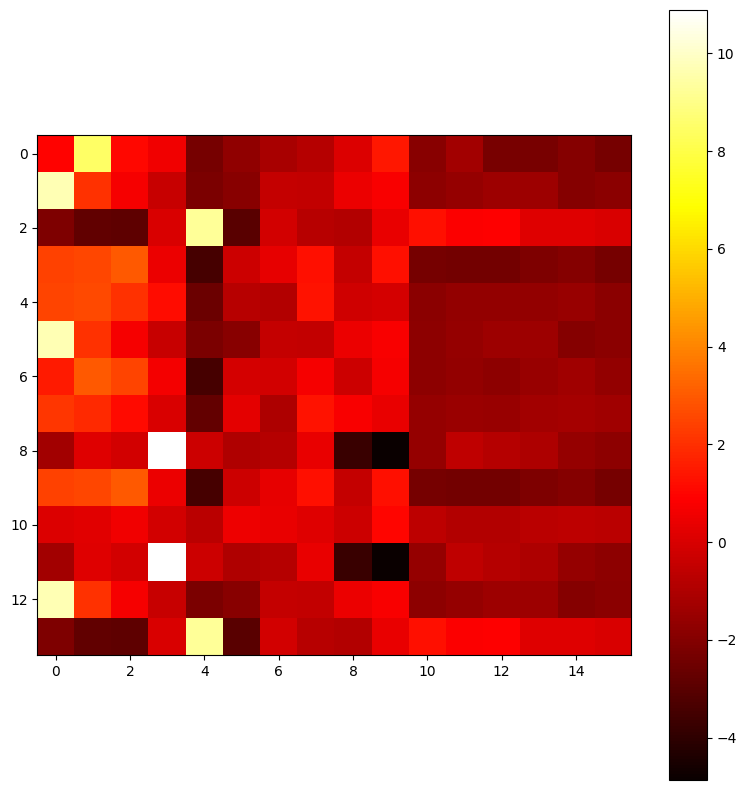

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

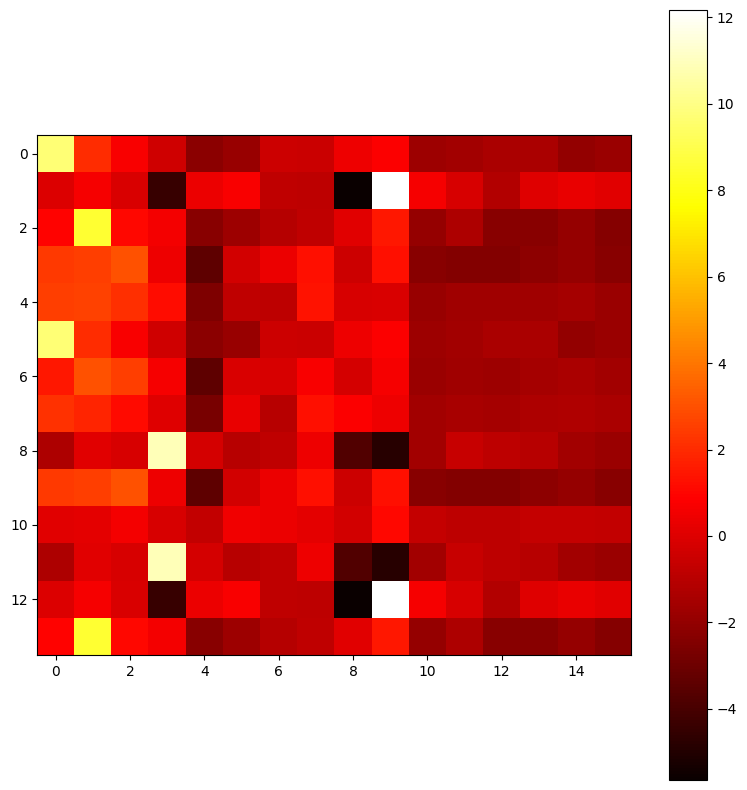

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

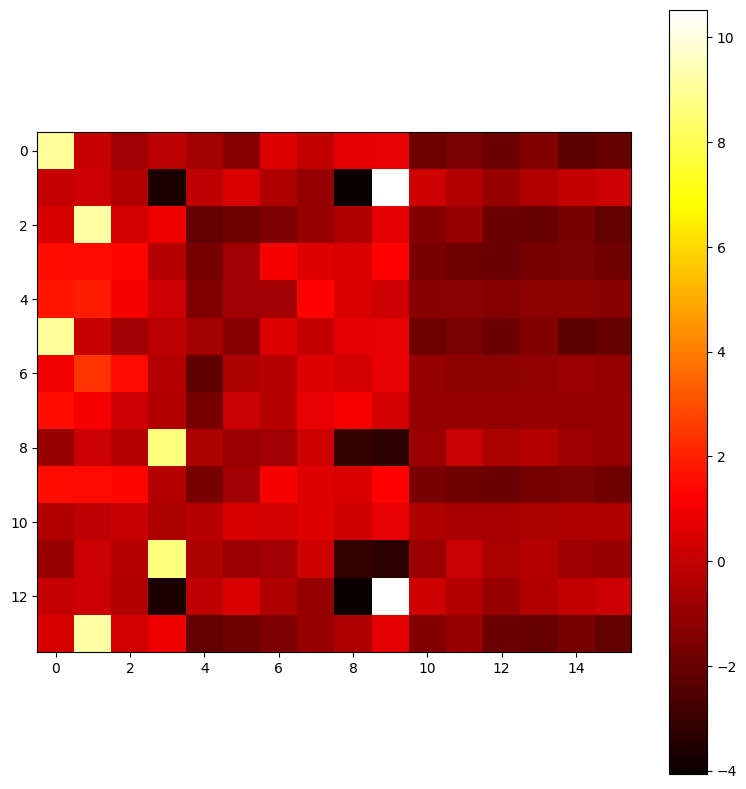

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(ov_circuit_attn_heatmap[1], cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

In [38]:
[(i, x, int2str[x]) for (i,x) in enumerate(ex_toks)]

[(0, 0, '0'),
 (1, 9, '9'),
 (2, 1, '1'),
 (3, 11, '\\n'),
 (4, 14, '['),
 (5, 0, '0'),
 (6, 15, ']'),
 (7, 13, '='),
 (8, 3, '3'),
 (9, 11, '\\n'),
 (10, 12, '>'),
 (11, 3, '3'),
 (12, 9, '9'),
 (13, 1, '1')]

In [40]:
def gen_viz():
    ex = gen_ex()
    tokens = torch.tensor(str_to_tokens(ex), dtype=torch.long).unsqueeze(0)
    logits, cache_model = model.run_with_cache(tokens, remove_batch_dim=True) 
    tokens_input = [int2str[t] for t in tokens.tolist()[0]]

    p0 = cache_model["pattern", 0, "attn"]
    return cv.attention.attention_patterns(tokens=tokens_input, attention=p0)


In [41]:
gen_viz()